In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.3:34341")
client

Client Scheduler: tcp://10.32.16.3:34341 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 5 Cores: 10 Memory: 57.50 GB


# WOA Data
To compare with SOSE and ECCOv4r3 products

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker
import xarray as xr
import gsw
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask

In [3]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
lower_lat = -79.5
upper_lat = -61.5
left_lon = -64.5
right_lon = 30.5

In [4]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

# <span style='color:Orange'> 1981 - 2010 period

In [5]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [6]:
ds.tse

<xarray.DataArray 'tse' (time: 1, lev: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  standard error about the statistical mean sea water temperatu...

## <span style='color:Brown'> Converting __psu__ to __Absolute Salinity__ and __in situ__ temperature to __potential__ temperature

In [7]:
tan = ds.tan.load()

In [8]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, tan.lev, ds.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [9]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, ds.san, pressure, ds.lon, ds.lat,
                    output_dtypes=[ds.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [10]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, tan, pressure,
                    output_dtypes=[tan.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [11]:
# this gives us the depth of the bottom cell
lev_max = pt.lev.where(pt.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom = pt.sel(lev=lev_max.fillna(0.))

In [12]:
pt_bottom_wg = pt_bottom.sel(**lat_range, **lon_range)

In [13]:
surface_mask_pt = (pt_bottom_wg.notnull()).load()

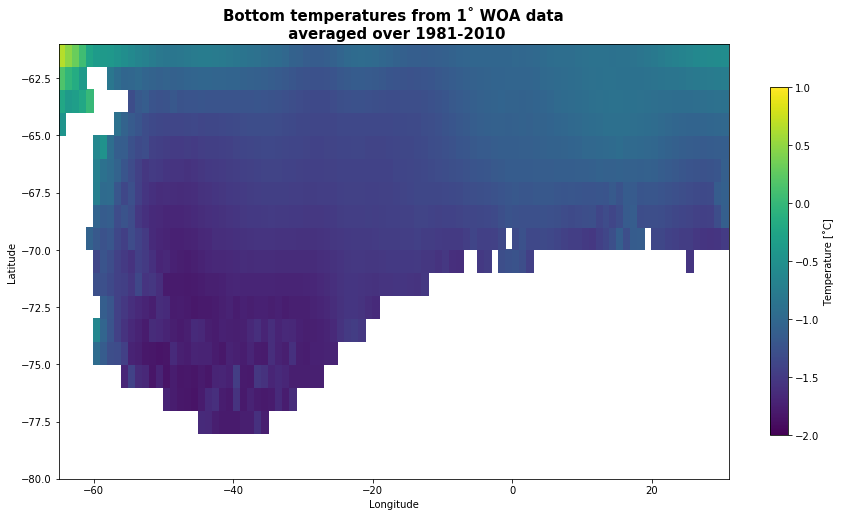

In [14]:
pt_bottom_wg.where(surface_mask_pt).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, vmin=-2, vmax=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [15]:
pt_bottom_wg = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
pt_bottom_wg

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

In [16]:
pt_bottom_wg.PT[0]

<xarray.DataArray 'PT' (lat: 19, lon: 96)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.213153, -0.37806 , -0.331057, ..., -0.905584, -0.891283, -0.878782],
       [ 0.160874, -0.032845, -0.15345 , ..., -0.762277, -0.747777, -0.736376],
       [ 0.661696,  0.478878,  0.311691, ..., -0.571269, -0.561768, -0.552068]])
Coordinates:
    time     datetime64[ns] 2000-01-15
    lev      (lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5

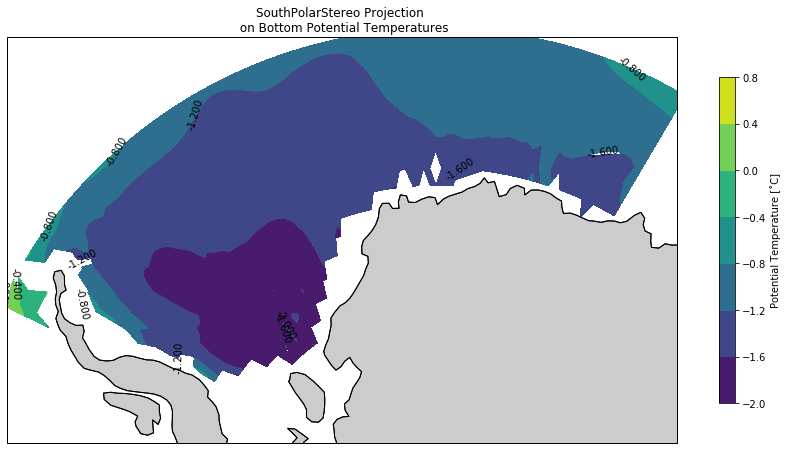

In [17]:
proj = ccrs.SouthPolarStereo()


fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)
ax.set_extent([-65, 30, -80, -62], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')
C = ax.contourf(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree())
fig.colorbar(C, shrink=0.4, label='Potential Temperature [˚C]')
#ax.set_yticks(np.arange(-79.5,-61.5,2))
#ax.set_xticks(np.arange(-64.5,30.5,10))
ax.clabel(C, colors='k')
plt.title('SouthPolarStereo Projection \n on Bottom Potential Temperatures');

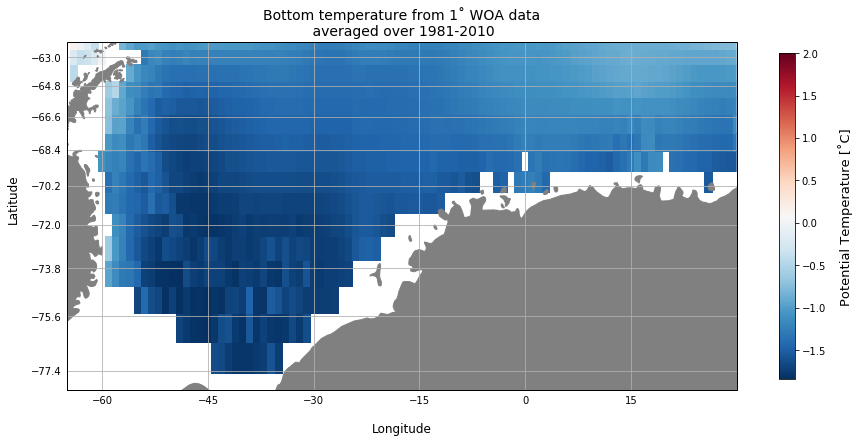

In [45]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
#ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))#cfeature.COLORS['land']))

#C = ax.contourf(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree())#, levels=np.arange(-2, 1, 0.2))
#ax.clabel(C, colors='k')
#fig.colorbar(C, ax=ax, shrink=0.4, label='Potential Temperature [˚C]')
im = ax.pcolormesh(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

#ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
#basins = regionmask.defined_regions.natural_earth.ocean_basins_50
#mask = basins.mask(pt_bottom_wg.lon, pt_bottom_wg.lat)
#mask.plot(add_colorbar=False, ax=ax);
#ax.set_xlim(xmin=-78)
plt.title('Bottom temperature from 1˚ WOA data\n averaged over 1981-2010', fontsize=14);

## <span style='color:Brown'> Bottom Practical Salinities

In [19]:
# this gives us the depth of the bottom cell
lev_max_slt = ds.san.lev.where(ds.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom = ds.san.sel(lev=lev_max_slt.fillna(0.))

In [20]:
san_bottom_wg = san_bottom.sel(**lat_range, **lon_range)

In [21]:
surface_mask_san = (san_bottom_wg.notnull()).load()

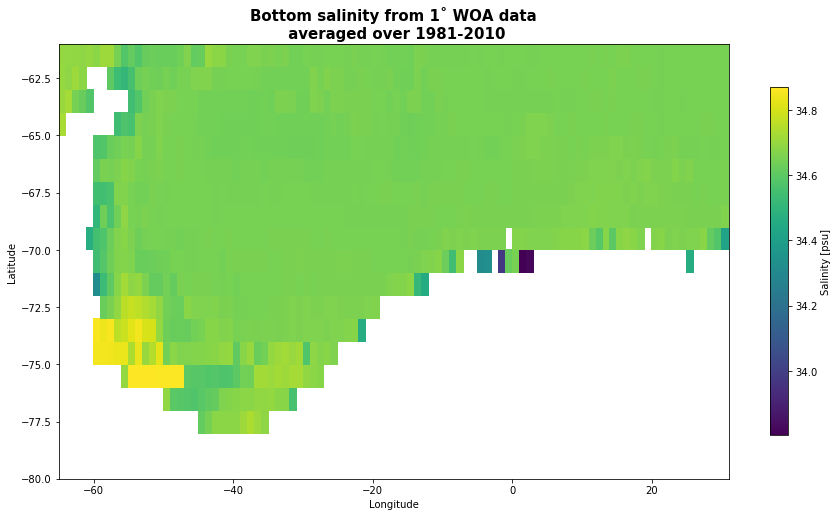

In [22]:
san_bottom_wg.where(surface_mask_san).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

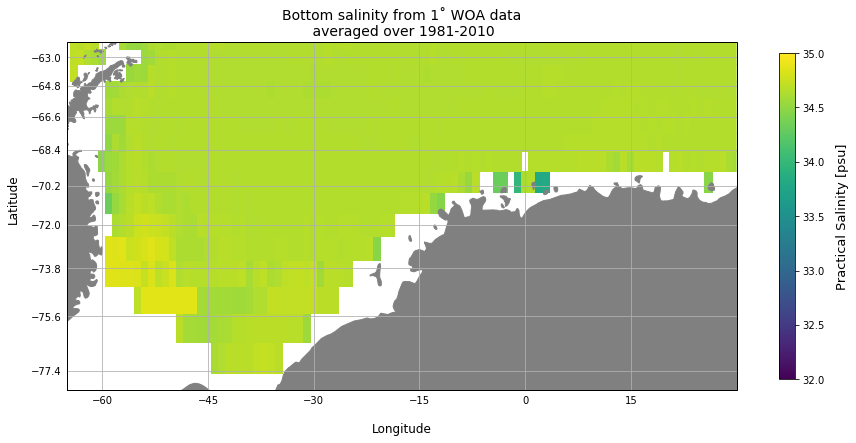

In [46]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg.lon, san_bottom_wg.lat, san_bottom_wg[0], cmap='viridis', vmin=32, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=14, );

# <span style='color:Orange'> 2005 - 2017 period

In [24]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

## <span style='color:Brown'> Converting __psu__ to __Absolute Salinity__ and __in situ__ temperature to __potential__ temperature

In [25]:
tan_0517 = ds_0517.tan.load()

In [26]:
#change levels to pressure
pressure_0517 = xr.apply_ufunc(gsw.p_from_z, tan_0517.lev, tan_0517.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure_0517.name = 'pressure'

In [27]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa_0517 = xr.apply_ufunc(gsw.SA_from_SP, ds_0517.san, pressure_0517, ds_0517.lon, ds_0517.lat,
                    output_dtypes=[ds_0517.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_0517.name = 'SA'

In [28]:
pt_0517 = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, tan_0517, pressure_0517,
                    output_dtypes=[tan_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [29]:
# this gives us the depth of the bottom cell
lev_max_0517 = pt_0517.lev.where(pt_0517.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517 = pt_0517.sel(lev=lev_max_0517.fillna(0.))

In [30]:
pt_bottom_wg_0517 = pt_bottom_0517.sel(**lat_range, **lon_range)

In [31]:
surface_mask_pt_0517 = (pt_bottom_wg_0517.notnull()).load()

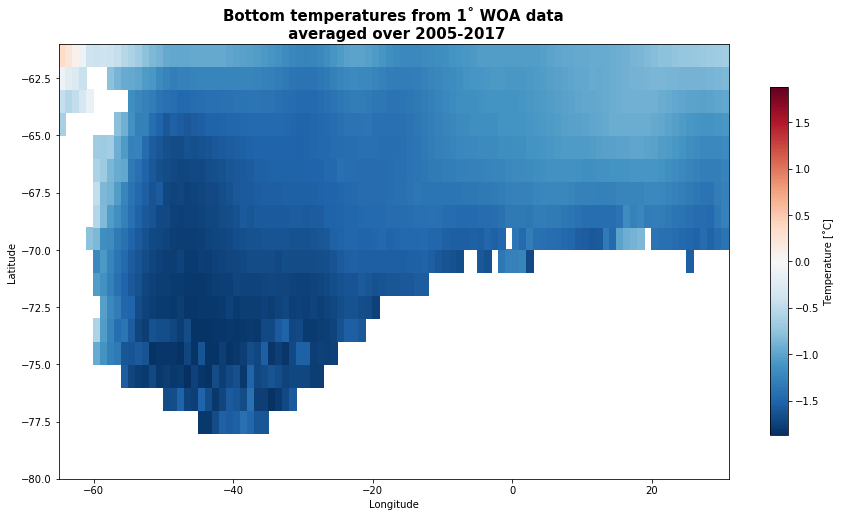

In [32]:
pt_bottom_wg_0517.where(surface_mask_pt_0517).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [33]:
pt_bottom_wg_0517 = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_0517.nc')
pt_bottom_wg_0517

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

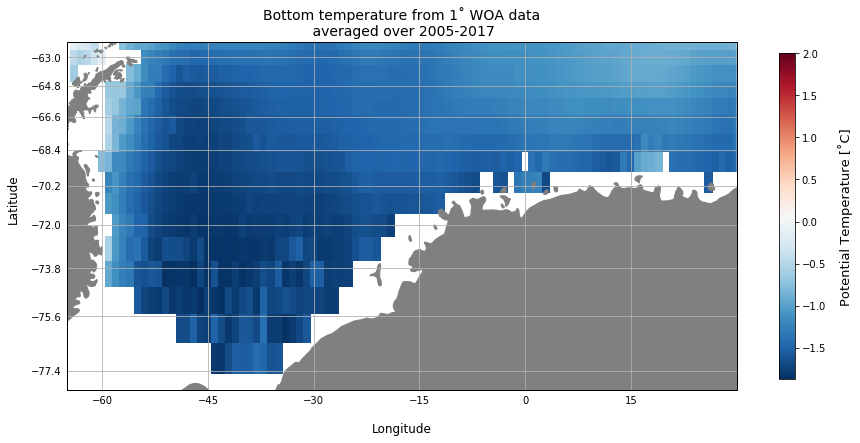

In [42]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517.lon, pt_bottom_wg_0517.lat, pt_bottom_wg_0517.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Potential Temperature [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from 1˚ WOA data\n averaged over 2005-2017', fontsize=14);

## <span style='color:Brown'> Bottom Absolute Salinities

In [35]:
# this gives us the depth of the bottom cell
lev_max_slt_0517 = ds_0517.san.lev.where(ds_0517.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517 = ds_0517.san.sel(lev=lev_max_slt_0517.fillna(0.))

In [36]:
san_bottom_wg_0517 = san_bottom_0517.sel(**lat_range, **lon_range)

In [37]:
surface_mask_san_0517 = (san_bottom_wg_0517.notnull()).load()

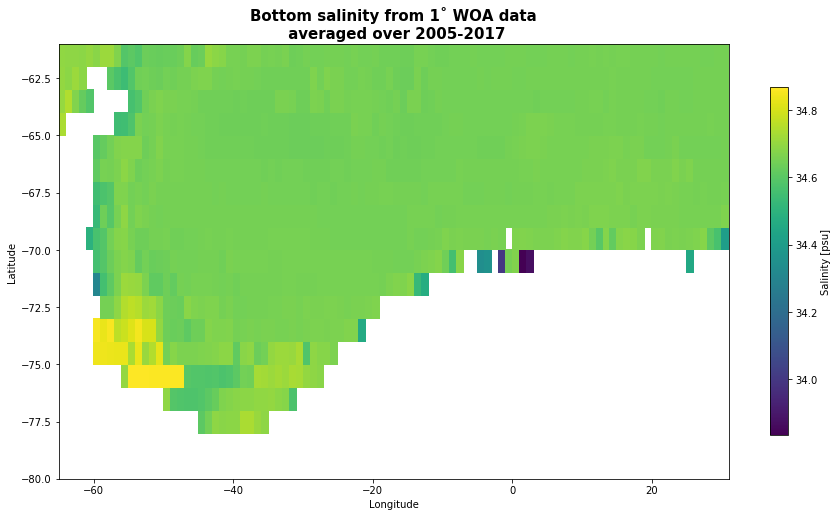

In [38]:
san_bottom_wg_0517.where(surface_mask_san_0517).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

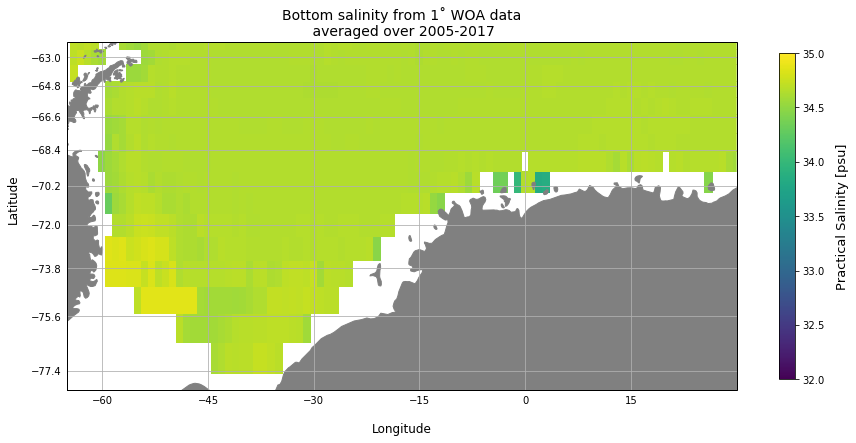

In [47]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517.lon, san_bottom_wg_0517.lat, san_bottom_wg_0517[0], cmap='viridis', vmin=32, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=14, );